## IT21169144 - DL - Lab 07

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [5]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1)
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 0.80749065],
         [ 0.9130192 ],
         [ 0.26797557],
         ...,
         [-0.73134303],
         [ 0.79183555],
         [-1.1428928 ]],

        [[ 1.1349577 ],
         [ 1.063621  ],
         [ 1.4413644 ],
         ...,
         [ 0.4103579 ],
         [ 0.5908093 ],
         [-0.9422164 ]],

        [[ 0.5121005 ],
         [-0.6137201 ],
         [ 0.98039776],
         ...,
         [ 0.29028016],
         [ 0.46486744],
         [-0.554486  ]],

        ...,

        [[-1.0048455 ],
         [-0.29970995],
         [ 0.8882253 ],
         ...,
         [ 0.05160246],
         [-0.7305853 ],
         [ 1.1094234 ]],

        [[-0.5439316 ],
         [ 1.3272834 ],
         [-0.24273023],
         ...,
         [ 0.3736307 ],
         [ 0.01987397],
         [ 1.3452779 ]],

        [[-1.4148246 ],
         [ 0.2620777 ],
         [-1.8219968 ],
         ...,
         [-0.9528006 ],
         [ 0.331

In [7]:
noise_factor = 0.2
x_train_noisy = x_train  +  noise_factor * tf.random.normal(shape=x_train.shape)
# noise factor multiplication result in increased spread in noise distribution
# result in 0.2^2 increase of variance, mean doesn't chnage (mean = 0)
x_test_noisy = x_test  +  noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [8]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

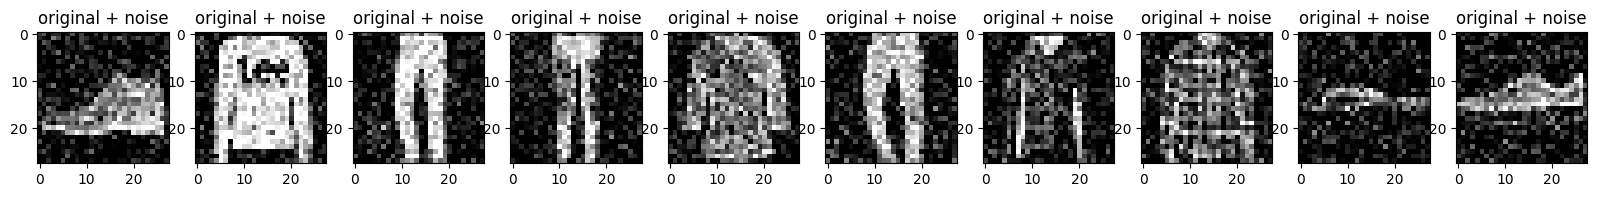

In [9]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [10]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [11]:
autoencoder = Denoise()

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
noise_factors = [0.1, 0.2, 0.3, 0.4, 0.5]

In [14]:
!pip install scikit-image

In [15]:
from skimage.util import random_noise  # Import random_noise function

for noise_factor in noise_factors:
    # Add noise to the test data
    x_test_noisy = np.array([random_noise(image, var=noise_factor) for image in x_test])

    # Clip noisy data to [0, 1] range
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

    # Define denoising autoencoder architecture
    class Denoise(Model):
        def __init__(self):
            super(Denoise, self).__init__()
            self.encoder = tf.keras.Sequential([
                layers.Input(shape=(28, 28, 1)),
                layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
                layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

            self.decoder = tf.keras.Sequential([
                layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

In [16]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0316 - val_loss: 0.0595
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0090 - val_loss: 0.0616
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0079 - val_loss: 0.0660
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0074 - val_loss: 0.0651
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0072 - val_loss: 0.0665
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0071 - val_loss: 0.0673
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0070 - val_loss: 0.0696
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0070 - val_loss: 0.0669
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0069 - val_loss: 0.0705
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0069 - val_loss: 0.0696
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0068 - val_loss: 0.0691
Epoch 12/30
1875/1875 ━━━━━━━

In [17]:
# Calculate the loss
test_loss = autoencoder.evaluate(x_test_noisy, x_test_noisy)
print("Test Loss (MSE) for Denoising Autoencoder:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0872
Test Loss (MSE) for Denoising Autoencoder: 0.08725808560848236


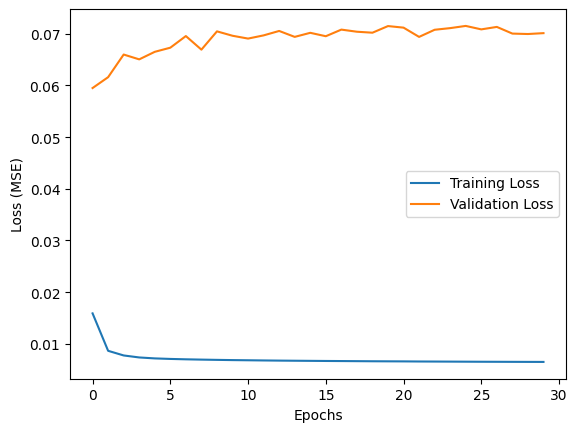

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [19]:
autoencoder.encoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
autoencoder.decoder.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

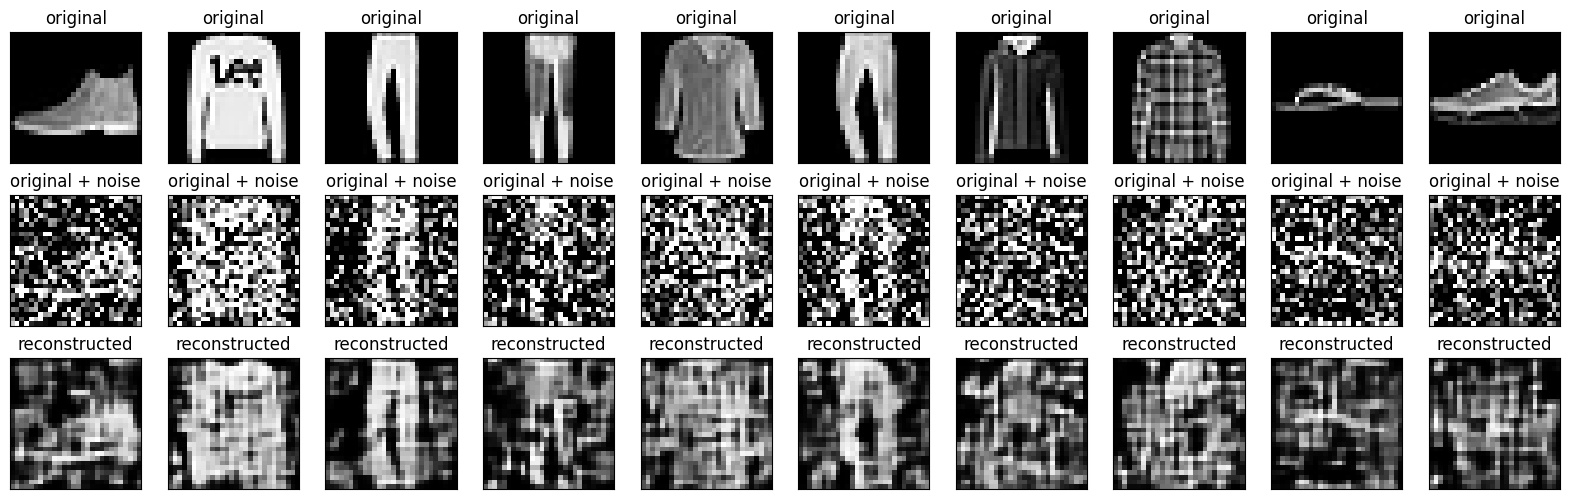

In [22]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()